# Model Selection

In [32]:
import numpy as np
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
from sklearn import datasets, neighbors
np.random.seed(1234)

In [33]:
# fetch the dataset
x, y = datasets.fetch_california_housing(return_X_y=True)
(num_instances, num_features), num_classes = x.shape, np.max(y) + 1
print(num_instances, num_features, num_classes)

# define MSE loss function
loss = lambda y, yh: np.mean((y-yh)**2)

20640 8 6.00001


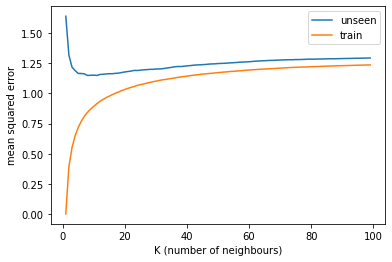

In [34]:
# Data split

num_test = num_instances // 5
# random permutation of indexes
inds = np.random.permutation(num_instances)

x_train, y_train = x[inds[num_test:]], y[inds[num_test:]]
x_test, y_test = x[inds[:num_test]], y[inds[:num_test]]

# test different values of K
K_list = range(1,100)
err_train, err_test = [], []

for i, K in enumerate(K_list):
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    model = model.fit(x_train, y_train)
    err_test.append(loss(model.predict(x_test), y_test))
    err_train.append(loss(model.predict(x_train), y_train))
    
plt.plot(K_list, err_test, '-', label='unseen')
plt.plot(K_list, err_train, '-', label='train')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()

The plot above shows that the best model according to our training data is not necessarly the best model when it comes to unseen data.

## Generalization Error

We care about the performance of the model on new data, we want to see how our model generalizes to unseen data that, we assume, comes from the same distribution.

We want to pick the hyper-parameter that gives us the best generalization error or test error. It would be a mistake to adjust our parameters based on test data, this could lead to overfit our test data.

### Validation Set

Solution is to set aside another subset, the validation set for doing model selection.

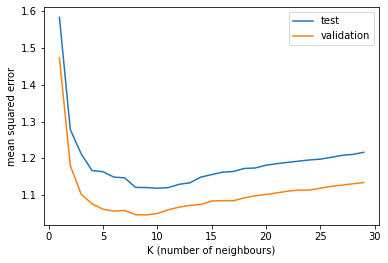

In [35]:
n_test, n_valid = num_instances // 10, num_instances // 10
inds = np.random.permutation(num_instances)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
x_valid, y_valid = x[inds[n_test:n_test+n_valid]], y[inds[n_test:n_test+n_valid]]
x_train, y_train = x[inds[n_test+n_valid:]], y[inds[n_test+n_valid:]]
# Range of values of K
K_list = range(1,30)

err_train, err_test, err_valid = [], [], []

for i, K in enumerate(K_list):
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    model = model.fit(x_train, y_train)
    err_test.append(loss(model.predict(x_test), y_test))
    err_valid.append(loss(model.predict(x_valid), y_valid))
    err_train.append(loss(model.predict(x_train), y_train))
    
plt.plot(K_list, err_test,  label='test')
#plt.plot(K_list, err_train,  label='train')
plt.plot(K_list, err_valid, label='validation')

plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()

## Cross Validation

Note that once we pick the best hyper-parameters for our model we can use both train+validation sets to retrain the model. This is only practical if training can be done efficiently.
In the figure above you can notice that validation error can be slightly different from the test error (simply re-run the code). This difference is due to the size of both validation and test sets. We can get a better estimate of the validation error and its variance using **cross validation**: the idea is to repeat the trainin-validation using a different portion of the data. Then we can use the mean and the variance of the training and validation error over these repetitions. For this, it is best to use non-overlapping validation sets: for example use, first we set asign 10% of the data for test. Then a 5-fold cross-validation, would divide the remaining 90% to 5 subsets. At each iteration of cross-validation, one of these 5 subsets will be used for validation and the remaining 4 will be used for training. Once we pick the best model using mean and variance of the validation error, we can train the model using the entire 90% of the data. Finally, we report the performance on the test set. Below we implement a method that returns train and validation split for cross-validation.

In [36]:
def cross_validate(n, n_folds=10):
    # get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        # get the validation indexes
        val_inds = list(range(f * n_val, (f+1) * n_val))
        
        # get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1) * n_val, n))
        
        # the yield statement suspends function's execution and sends 
        # back data but retains enough state information to enable function
        # to resume where it was
        yield tr_inds, val_inds

1. Set aside test data

In [37]:
inds = np.random.permutation(num_instances)
# separate test data
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]

# rest for training and validation
n_rest = num_instances - n_test

2. Use cross validation to find the best set of hyper-parameters

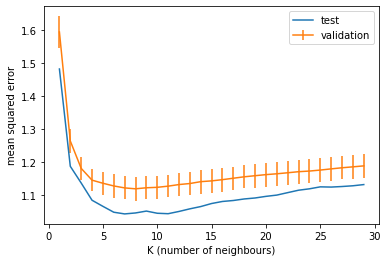

In [38]:
num_folds = 10

# we get a K x L matrix for error
# K: number of neighbors
# L: number of folds
err_test, err_valid = np.zeros(len(K_list)), np.zeros((len(K_list), num_folds))

for i, K in enumerate(K_list):
    #Find the validation errors for num_folds splits for a given K
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        model = neighbors.KNeighborsRegressor(n_neighbors=K)
        model = model.fit(x_rest[tr], y_rest[tr])
        # compute the validation error after fitting with the train data only
        err_valid[i, f] = loss(y_rest[val], model.predict(x_rest[val]))   
      
    # fit with the whole rest data
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    model = model.fit(x_rest, y_rest)
    err_test[i] = loss(y_test, model.predict(x_test))
    
# plot results with error bar
plt.plot(K_list, err_test,  label='test')
plt.errorbar(K_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()

A simple rule of thumb for picking the best model using cross-validation is to pick the simplest model that is within one standard deviation of the best performing model.
What if we have multiple hyper-parameters that should be optimized simultaneously? Some simple solutions are **grid-search** and **random-search** which exhustively or randomly search over joint assignments to hyper-parameters. 

## Evaluation Metrics
One could use criteria that are potentially different from the objective in a classification or regression task to evaluate a model.
For example, while it may be easier to optimize mean squared error in regression, we may be eventually interested in the relative error $\frac{|\hat{y}-y|}{|y + \epsilon|}$. Note that "ideally" we should try to optimize the quantity we are interested in. While some measures may be hard to optimize we can use them in model selection; for example in picking the best hyper-parameter.

### Confusion matrix
For classification, we can better understand the behaviour of our classifier by producing the *confusion matrix*. It tells us how much items in one class (rows) are assigned to another class by a classifier (columns). Let's use `scikit-learn`'s implementation of decision tree to learn a classifier.

In [39]:
from sklearn import tree, model_selection
x, y = datasets.load_iris(return_X_y=True)
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2) # this is similar to our manual split above
yh_test = tree.DecisionTreeClassifier().fit(x_train, y_train).predict(x_test)

In [40]:
def confusion_matrix(y, yh):
    n_classes = np.max(y) + 1
    c_matrix = np.zeros((n_classes, n_classes))
    for c1 in range(n_classes):
        for c2 in range(n_classes):
            # (y==c1) * (yh==c2) is 1 when both conditions are true or 0
            c_matrix[c1, c2] = np.sum((y==c1) * (yh==c2))
    return c_matrix

cmat = confusion_matrix(y_test, yh_test)
print(cmat)
print(f'accuracy: {np.sum(np.diag(cmat))/np.sum(cmat)}')

[[10.  0.  0.]
 [ 0. 10.  1.]
 [ 0.  2.  7.]]
accuracy: 0.9
